# Оценка метрик и валидация моделей

1. Скачайте датасет с kaggle-соревнования Kaggle: Facial Keypoints Detection

2. Задетектируйте при помощи выбранного выше landmark-детектора точки на лицах из этого датасета

3. Посчитайте метрики для Ground-Truth точек которые эквивалентны точкам из модели (в opencv 68-point модель, в kaggle разметка для 15-точек).

4. Подумайте, предложите метрики, которые стоит посчитать для этой задачи. Мы хотим при помощи этих метрик оценить несколько факторов:
    - оценить точность детектирования каждой из точек и всех точек в среднем
    - оценить точность позиционирования (насколько точки смещаются относительно GT) для каждой landmark и в среднем

5. Отберите и визуализируйте (изображение + точки Ground Truth + Predicts) 3-5 изображений с самым высоким качеством детектирования и с самым низким.

In [ ]:
import math
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
train_df = pd.read_csv('./facial-keypoints-detection/training.csv')
test_df = pd.read_csv('./facial-keypoints-detection/test.csv')

In [2]:
test_df.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [26]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def str_to_image(str_img):
    return np.array(str_img.split(), dtype=np.uint8).reshape(96, 96)

train_df['Image'] = train_df['Image'].apply(str_to_image)
test_df['Image'] = test_df['Image'].apply(str_to_image)

In [156]:
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) > 0:
        face = faces[0]
        landmarks = predictor(gray, face)
        model_68_points_dict = {
            'left_eye_center': ((landmarks.part(42).x + landmarks.part(45).x) // 2, (landmarks.part(42).y + landmarks.part(45).y) // 2),
            'right_eye_center': ((landmarks.part(36).x + landmarks.part(39).x) // 2, (landmarks.part(36).y + landmarks.part(39).y) // 2),
            'left_eye_inner_corner': (landmarks.part(42).x, landmarks.part(42).y),
            'left_eye_outer_corner': (landmarks.part(45).x, landmarks.part(45).y),
            'right_eye_inner_corner': (landmarks.part(39).x, landmarks.part(39).y),
            'right_eye_outer_corner': (landmarks.part(36).x, landmarks.part(36).y),
            'left_eyebrow_inner_end': (landmarks.part(22).x, landmarks.part(22).y),
            'left_eyebrow_outer_end': (landmarks.part(26).x, landmarks.part(26).y),
            'right_eyebrow_inner_end': (landmarks.part(21).x, landmarks.part(21).y),
            'right_eyebrow_outer_end': (landmarks.part(17).x, landmarks.part(17).y),
            'nose_tip': (landmarks.part(30).x, landmarks.part(30).y),
            'mouth_left_corner': (landmarks.part(54).x, landmarks.part(54).y),
            'mouth_right_corner': (landmarks.part(48).x, landmarks.part(48).y),
            'mouth_center_top_lip': (landmarks.part(51).x, landmarks.part(51).y),
            'mouth_center_bottom_lip': (landmarks.part(57).x, landmarks.part(57).y)
        }
        return model_68_points_dict
    return []


def get_ground_truth_points(row):
    true_points_dict = {}
    for column in train_df.columns:
        if column.endswith('_x'):
            key = column[:-2] 
            x_value = row[column]
            y_column = column[:-2] + '_y'
            y_value = row[y_column]
            true_points_dict[key] = (x_value, y_value)
    return true_points_dict




prediction = {}
my_metric = {}

for i in range(1,train_df['Image'].count()):
    sample_image = cv2.cvtColor(train_df.iloc[i]['Image'], cv2.COLOR_BGR2RGB)

    true_points_dict = get_ground_truth_points(train_df.iloc[i])
    detected_points_dict = detect_landmarks(sample_image)

    difference_dict = {}

    for key in true_points_dict.keys():
        if key in detected_points_dict:
            true_x, true_y = true_points_dict[key]
            detected_x, detected_y = detected_points_dict[key]
            # Евклидово расстояние
            difference_dict[key] = [true_x, detected_x, true_y, detected_y]
            difference_dict[key].append((true_x - detected_x,true_y - detected_y))
            difference_dict[key].append(math.sqrt((true_x - detected_x)**2 + (true_y - detected_y)**2))
            
            prediction[i] = pd.DataFrame.from_dict(difference_dict, orient='index', columns=['true_x','detected_x','true_y','detected_y','DiffCoord', 'Evklid'])
            my_metric[i] = prediction[i].Evklid.sum() / prediction[i].Evklid.count()


/var/folders/hd/zdtz4s_96nq3_p8__37vjsvh0000gn/T/ipykernel_29716/4192708102.py:72: RuntimeWarning: invalid value encountered in scalar divide
  my_metric[i] = prediction[i].Evklid.sum() / prediction[i].Evklid.count()


In [174]:
# Визуализация детектированных точек
def visualize_prediction(image, pred_df):
    for index, row in pred_df.iterrows():
        true_x = row["true_x"]
        true_y = row["true_y"]
        detected_x = row["detected_x"]
        detected_y = row["detected_y"]

        # Проверяем, что значения не NaN
        if not np.isnan(true_x) and not np.isnan(true_y):
            cv2.circle(image, (int(true_x), int(true_y)), 1, (0, 255, 0), -1) # зеленые

        if not np.isnan(detected_x) and not np.isnan(detected_y):
            cv2.circle(image, (int(detected_x), int(detected_y)), 1, (0, 0, 255), -1)   # красные

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

### Тестовое фото

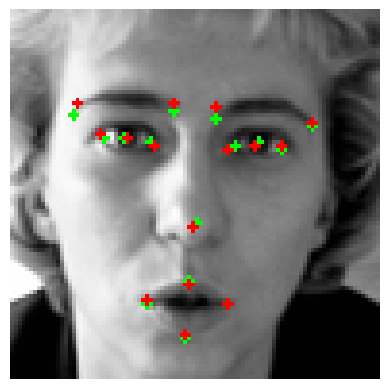

,true_x,detected_x,true_y,detected_y,DiffCoord,Evklid
left_eye_center,64.332936,63,34.970077,35,"(1.3329361702, -0.029923404299999845)",1.333272
right_eye_center,29.949277,30,33.448715,33,"(-0.05072340430000111, 0.4487148935999983)",0.451573
left_eye_inner_corner,58.856170,56,35.274349,36,"(2.856170212800002, -0.7256510638000009)",2.946910
left_eye_outer_corner,70.722723,70,36.187166,35,"(0.7227234042999982, 1.1871659573999978)",1.389853
right_eye_inner_corner,36.034723,37,34.361532,35,"(-0.9652765956999971, -0.6384680851000013)",1.157325
right_eye_outer_corner,24.472511,23,33.144443,32,"(1.472510638300001, 1.144442553200001)",1.864949
left_eyebrow_inner_end,53.987404,53,28.275949,25,"(0.9874042552999995, 3.275948936199999)",3.421521
left_eyebrow_outer_end,78.634213,78,30.405923,29,"(0.6342127660000045, 1.405923404300001)",1.542351
right_eyebrow_inner_end,42.728851,42,26.146043,24,"(0.7288510638000005, 2.146042553200001)",2.266434
right_eyebrow_outer_end,16.865362,17,27.058860,24,"(-0.13463829790000048, 3.0588595745000013)",3.061821


In [176]:
# ВЫБЕРИ ФОТО
pic = 1

sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
visualize_prediction(sample_image, prediction[pic])
prediction[pic]

## Наихудшее качество детектирования


Топ 5 наибольших значений:
image 1907: 39.72702738990525


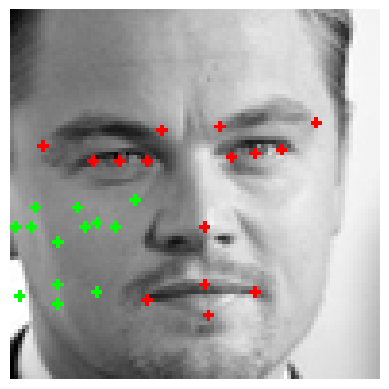

image 1877: 33.71235701276306


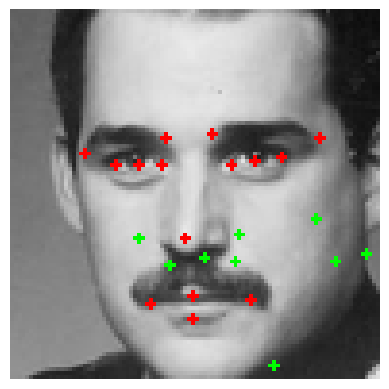

image 2199: 22.454035451877765


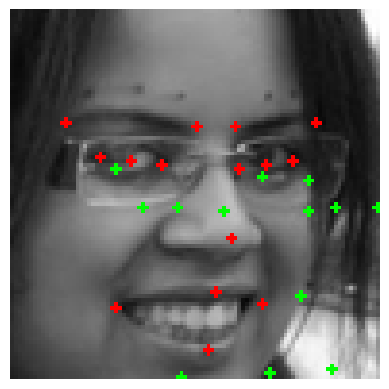

image 5933: 20.883161989666917


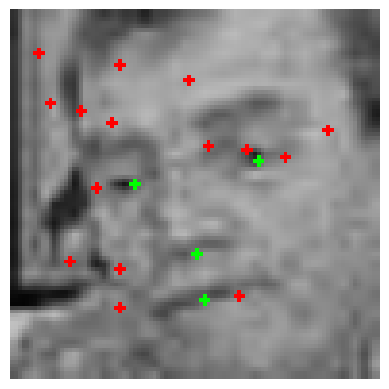

image 1953: 16.83310343667811


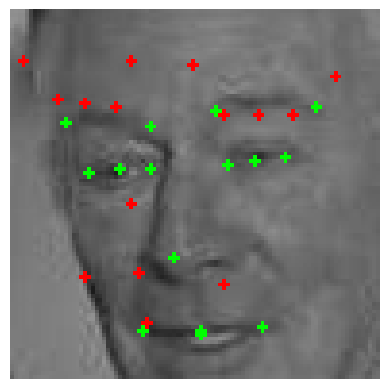

In [178]:
# Топ 5 наибольших значений
top_largest = sorted(my_metric.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nТоп 5 наибольших значений:")
for pic, value in top_largest:
    print(f"image {pic}: {value}")
    sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
    visualize_prediction(sample_image, prediction[pic])

In [ ]:
def visualize_prediction(pic, pred_df):
    
    image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
    for index, row in pred_df.iterrows():
        true_x = row["true_x"]
        true_y = row["true_y"]
        detected_x = row["detected_x"]
        detected_y = row["detected_y"]

        # Проверяем, что значения не NaN
        if not np.isnan(true_x) and not np.isnan(true_y):
            cv2.circle(image, (int(true_x), int(true_y)), 1, (0, 255, 0), -1)

        if not np.isnan(detected_x) and not np.isnan(detected_y):
            cv2.circle(image, (int(detected_x), int(detected_y)), 1, (0, 0, 255), -1)   

## Наилучшее качество детектирования


Топ 5 наименьших значений:
image 1259: 0.9799947114054232


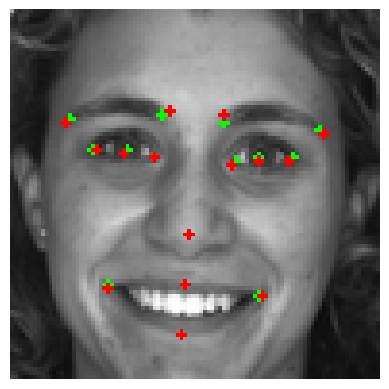

image 1566: 1.032893671107836


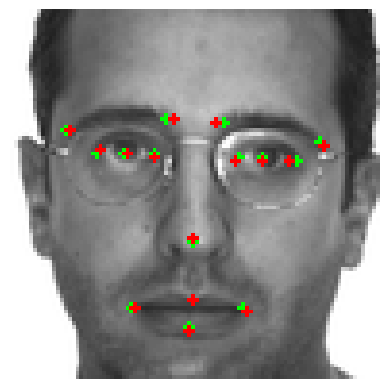

image 2125: 1.043057013659586


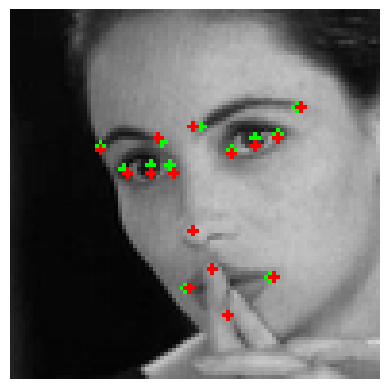

image 1240: 1.0718036623278047


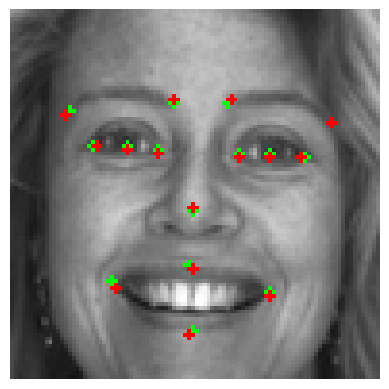

image 884: 1.076017659572318


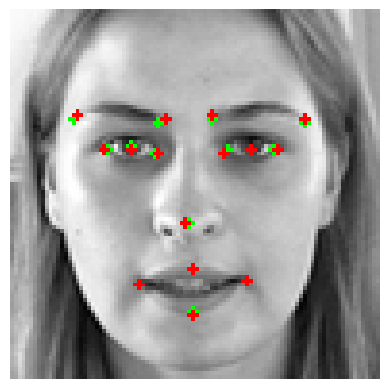

In [179]:
# Топ 5 наименьших значений
top_smallest = sorted(my_metric.items(), key=lambda x: x[1], reverse=False)[:5]

print("\nТоп 5 наименьших значений:")
for pic, value in top_smallest:
    print(f"image {pic}: {value}")
    sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
    visualize_prediction(sample_image, prediction[pic])